In [6]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [7]:
df = pd.read_excel(r'RetailPulseAssignmentData.xlsx')

In [8]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [18]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'date', 'sales'],
      dtype='object')

In [28]:
import datetime as dt
now = df["date"].max() + dt.timedelta(days=1)
rfm_df = df.groupby("Customer ID").agg({
    "date": lambda x: (now - x.max()).days,
    "Invoice": "nunique",
    "sales": "sum"
})
rfm_df.rename(columns={"date": "Recency", "Invoice": "Frequency", "sales": "Monetary"}, inplace=True)
r_quantiles = pd.qcut(rfm_df["Recency"], q=4, labels=False)
f_quantiles = pd.qcut(rfm_df["Frequency"], q=4, labels=False)
m_quantiles = pd.qcut(rfm_df["Monetary"], q=4, labels=False)
rfm_df = rfm_df.assign(R=r_quantiles, F=f_quantiles, M=m_quantiles)
rfm_df["RFM"] = rfm_df["R"].astype(str) + f_quantiles.astype(str) + m_quantiles.astype(str)
rfm_segments = {
    "Best Customers": ["444"],
    "Loyal Customers": ["334", "344", "434", "444"],
    "Big Spenders": ["344", "434", "444"],
    "Almost Lost": ["244", "234", "224"],
    "Lost Customers": ["144", "134", "124"],
    "Lost Cheap Customers": ["111"]
}
rfm_df["Segment"] = "Other"
for segment, rfm in rfm_segments.items():
    rfm_df.loc[rfm_df["RFM"].isin(rfm), "Segment"] = segment
print(rfm_df["Segment"].value_counts())

ValueError: Bin edges must be unique: array([  1.,   1.,   3.,   6., 270.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

2. How would you define a loyal customer?

To define a loyal customer in the given dataset using pandas, we can consider the following criteria:

Number of purchases: A customer who has made a certain number of purchases can be considered loyal. For example, a customer who has made more than five purchases can be considered loyal.

Total sales amount: A customer who has spent a certain amount of money can be considered loyal. For example, a customer who has spent more than $1000 can be considered loyal.

In [24]:
customer_purchases = df.groupby("Customer ID")["Invoice"].nunique()
loyal_customers = customer_purchases[customer_purchases > 5].index.tolist()
customer_sales = df.groupby("Customer ID")["sales"].sum()
loyal_customers = customer_sales[customer_sales > 1000].index.tolist()
len(loyal_customers)

1680

3. What is the most popular time of year based on this sales data?

In [27]:
df["date"] = pd.to_datetime(df["InvoiceDate"])
df['sales'] = df['Quantity'] * df['Price']
popular_time = df.groupby([df["InvoiceDate"].dt.year, df["InvoiceDate"].dt.month])["sales"].sum().sort_values(ascending=False)
print(popular_time)

InvoiceDate  InvoiceDate
2010         11             1422654.642
             10             1045168.350
             9               853650.431
2009         12              799847.110
2010         3               765848.761
             6               679786.610
             8               656776.340
             1               624032.892
             5               615322.830
             4               590580.432
             7               575236.360
             2               533091.426
             12              377488.450
Name: sales, dtype: float64


4. Is there any seasonality in data? Explain with supportive evidence.

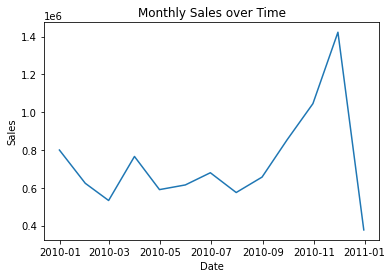

In [19]:
df["date"] = pd.to_datetime(df["InvoiceDate"])
monthly_sales = df.groupby(pd.Grouper(key="date", freq="M")).sum()["sales"]
plt.plot(monthly_sales)
plt.title("Monthly Sales over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

5. Discuss customer's lifetime with respect to the given dataset.

In [20]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
customer_lifetime = df.groupby("Customer ID")["InvoiceDate"].agg(["min", "max"])
customer_lifetime["lifetime"] = (customer_lifetime["max"] - customer_lifetime["min"]).dt.days
print(customer_lifetime.sort_values(by="lifetime", ascending=False))

                            min                 max  lifetime
Customer ID                                                  
12682.0     2009-12-01 09:28:00 2010-12-09 14:49:00       373
17700.0     2009-12-01 11:37:00 2010-12-09 15:33:00       373
18102.0     2009-12-01 09:24:00 2010-12-09 13:44:00       373
15380.0     2009-12-01 13:50:00 2010-12-09 15:01:00       373
15311.0     2009-12-01 11:21:00 2010-12-09 14:15:00       373
...                         ...                 ...       ...
12691.0     2010-10-15 12:00:00 2010-10-15 12:00:00         0
15383.0     2010-01-26 16:24:00 2010-01-26 16:24:00         0
12692.0     2010-03-12 14:02:00 2010-03-12 14:02:00         0
15387.0     2010-08-04 16:05:00 2010-08-04 16:05:00         0
15931.0     2010-10-07 16:46:00 2010-10-07 16:46:00         0

[4383 rows x 3 columns]
